# Learning Cuves

---

__This Notebook__

- plot learning curves for the best random forest and adaboost classifiers
- try a final voting classifier
- what about stacking?

__Other Candidates__

```
rnd_clf = RandomForestClassifier(
    random_state=42
    , n_estimators=100
    , max_features=150
    , max_depth=8
    , min_samples_split=3 # 2 overfits?
    , warm_start=True # to speed up learning curves
    , n_jobs=1
)
    
ada_clf =  AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier()
    , algorithm='SAMME.R'
    , random_state=42
    , n_estimators=10 # 20 overfits?
    , learning_rate=0.001 # 0.1 overfits?
)

vot_clf_hard = VotingClassifier(
    estimators=[('rdn', rnd_clf), 
                ('ada', ada_clf), 
                ('gb1', gb1_clf)] # best gb classifier
    , voting='hard'
)
```


__Gradient Boosting Candidates__

```
clf1a = GradientBoostingClassifier(
    random_state=42,
    n_estimators=50,
    max_features=None, # default (all features)
    max_depth=1,
    min_samples_split=2, # default
    learning_rate=0.1 # default
)

clf2a = GradientBoostingClassifier(
    random_state=42, 
    n_estimators=100, # default
    max_features=300,
    max_depth=8, 
    min_samples_split=5, 
    learning_rate=0.1 # default
)

clf2c = GradientBoostingClassifier(
    random_state=42,
    n_estimators=50, # lowered
    max_features=300,
    max_depth=3,
    min_samples_split=5,    
    learning_rate=0.1
)

```

__Next__

- what now?

## Setup

In [2]:
import re
import os
import time
import joblib 

import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.model_selection import train_test_split, \
    ShuffleSplit, StratifiedKFold, learning_curve
from sklearn.metrics import make_scorer, accuracy_score, \
    recall_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, \
    RandomForestClassifier, GradientBoostingClassifier, \
    VotingClassifier

dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2021-02-15


## Load

In [3]:
# load target 
raw_path = os.path.join("data","1_raw")
y_df = pd.read_csv(os.path.join(raw_path, 'y_train.csv'))
y_array = np.array(y_df.iloc[:,0].ravel())
y = y_array.copy()
y[y=='ham'] = 0
y[y=='spam'] = 1
y = y.astype('int')

# load matrix
proc_dir = os.path.join("data", "2_processed")
X = sp.load_npz(os.path.join(proc_dir, 
                             'X_tfidf_svd800_spamcos.npz'))

## Functions

In [4]:
def train_plot(clf, X, y, cv, verbose, train_sizes, n_jobs, 
               scorer_, metric, axes, axis):
    """
    Trains and plots learning_curves, given:
        scorer_: a make_scorer object
        metric: str, the name of the metric
    ...and all other args passed to learning_curve in the 
    plot_learning_curve function.
    """
    # train
    train_sizes, train_scores, test_scores = \
        learning_curve(clf, X, y, cv=cv, verbose=verbose,
                       train_sizes=train_sizes, n_jobs=n_jobs,
                       scoring=scorer_)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)    
    
    # plot
    axes[axis].grid()
    axes[axis].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[axis].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[axis].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[axis].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[axis].legend(loc="lower right")
    axes[axis].set_ylabel(metric)

In [20]:
def plot_learning_curve(clf, title, X, y, axes=None, ylim=(.95, 1.01), 
                        cv=5, train_sizes=np.linspace(.1, 1.0, 5),
                        verbose=0, n_jobs=-1):
    """
    Adapted from the Plot Learning Curves example in Scikit-Learn 
    to show only the performance of a scorer, using accuracy, 
    sensitivity, and specificity as metrics.
    """
    # set axes, title, ylims, xlabel
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 12))
    
    axes[0].set_title(title)
    axes[2].set_xlabel("Training Examples")
    
    if ylim is not None:
        axes[0].set_ylim(*ylim)
        axes[1].set_ylim(*ylim)
        axes[2].set_ylim(*ylim)

    # setup scorers
    scorers = {
        'acc': make_scorer(accuracy_score),
        'tpr': make_scorer(recall_score, pos_label=1), # sensitivity
        'tnr': make_scorer(recall_score, pos_label=0) # specificity
    }

    # plots
    train_plot(clf, X, y, cv=cv, verbose=verbose, 
               train_sizes=train_sizes, n_jobs=n_jobs, 
               scorer_=scorers['acc'], metric='Accuracy', 
               axes=axes, axis=0)
    train_plot(clf, X, y, cv=cv, verbose=verbose, 
               train_sizes=train_sizes, n_jobs=n_jobs, 
               scorer_=scorers['tpr'], metric='Sensitivity', 
               axes=axes, axis=1)
    train_plot(clf, X, y, cv=cv, verbose=verbose, 
               train_sizes=train_sizes, n_jobs=n_jobs, 
               scorer_=scorers['tnr'], metric='Specificity', 
               axes=axes, axis=2)
    
    return plt

In [21]:
def compare_two_classifiers(clf1, clf2, title1, title2):
    """
    Wrapper for plot_learning_curve with a timer.
    Compares two classifiers' learning curves.
    """
    t = time.time()
    fig, axes = plt.subplots(3, 2, figsize=(16, 16))
    plot_learning_curve(clf1, title1, X, y, axes=axes[:, 0], cv=cv)
    plot_learning_curve(clf2, title2, X, y, axes=axes[:, 1], cv=cv)
    m, s = divmod(time.time() - t, 60)
    print(f'Elapsed: {m:0.0f} m {s:0.0f} s')
    plt.show()     

## Comparison plots

The two classifiers I begin with are the best from the gradient boosting notebooks 2 and 3. 

- Clf1 has 50 trees, 3000 features, max depth 1, min samples split 2
- Clf2 has 100 trees, 300 features, max depth 8, min samples split 5
- Both have a learning rate $\eta=0.1$

In [22]:
# 10-fold cross validation
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42) 

### AdaBoost

In [23]:
# define classifiers
ada1_title = r"AdaBoost, 10 trees, $\eta=0.001$"
ada2_title = r"AdaBoost, 10 trees, $\eta=0.01$"

ada_clf1 =  AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier()
    , algorithm='SAMME.R'
    , random_state=42
    , n_estimators=10 # 20 overfits? 
    , learning_rate=0.001
)

ada_clf2 =  AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier()
    , algorithm='SAMME.R'
    , random_state=42
    , n_estimators=10
    , learning_rate=0.01 # 0.1 overfits?
)

Elapsed: 1 m 6 s


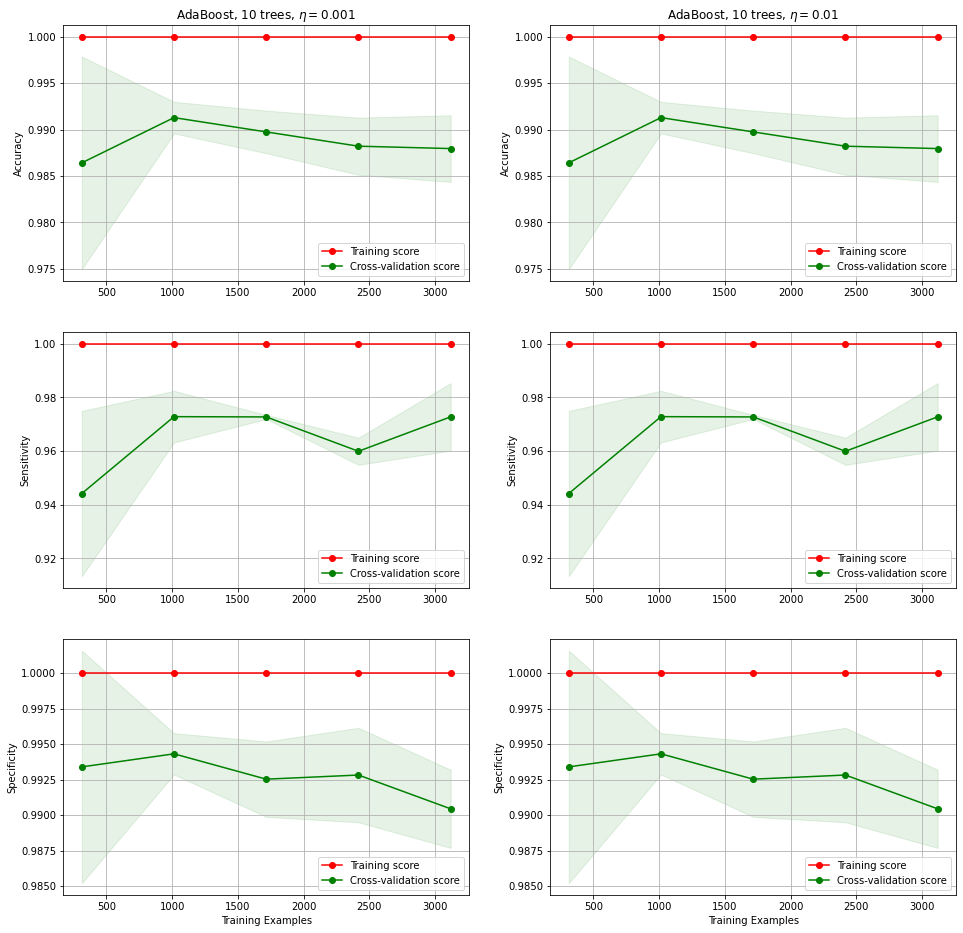

In [24]:
compare_two_classifiers(ada_clf1, ada_clf2, ada1_title, ada2_title)

__Results__



__Next__



### Random Forests

In [17]:
# define classifiers
rnd_title1 = r"RandomForest, 100 trees, 150 feat, depth 8, split 3"
rnd_title2 = r"RandomForest, 100 trees, 150 feat, depth 8, split 2"

rnd_clf1 = RandomForestClassifier(
    random_state=42
    , n_estimators=100
    , max_features=150
    , max_depth=8
    , min_samples_split=3
    , warm_start=True
    , n_jobs=1
)

rnd_clf2 = RandomForestClassifier(
    random_state=42
    , n_estimators=100 
    , max_features=150
    , max_depth=8
    , min_samples_split=2 # 2 overfits?
    , warm_start=True
    , n_jobs=1
)

In [25]:
compare_two_classifiers(rnd_clf1, rnd_clf2, rnd_title1, rnd_title2)

__Results__



__Next__



---